<h2> Lab 8

<h3> Exercise Set 1

**(a) Scenario 1**: You have a dataset of 300 documents containing numerical and text records of different nuclear units. Your task is to develop a model that can process similar documents and classify the data based on reactor design (PWR or BWR) and the length of the reactor life (< 40 years, > 40 years but < 60 years, > 60 years).

This is a simply classification problem, although it may be challenging due to a small sample size. I will go with a FNN.

Input layer: All number and text fields from the document are encoded and inputted here. <br>
Dense layers: At least 5, with decreasing nodes from the size of the input layer down to 20 or so. relu activation <br>
Dropout layer: A modest dropout layer would be inserted between the 1st and 2nd dense layer with a dropout rate of 0.1 <br>
Output layer: two outputs, with a softmax activation function.

Loss could be categorical crossentropy with Adam as the optimizer and accuracy as an evaulation metric. I would also utilize k-fold cross validation (k=10) to help make up for the small training size.


**(b) Scenario 2**: You have a dataset of 5000 images of different pipes in a nuclear power plant unit. Your task is to develop a model that can predict the health of similar pipes and classify them into different grades: High, medium, low, or about to break.

This is an image classification problem, so I would use a Convolutional Neural Network. Since the health of the pipe is important rather than the general shape, I would be conservative with pooling, but would add it in as needed due to memory or training limitations using filters of size (2,2) through size (5,5). 

Input layer: shape is (image height, image width, image channels) <br>
Convolutional Layer 1-5: increasing number of filters from 16-128, relu activation <br>
Flattening Layer: to get vector <br>
Dense Layer: Fully connected to all flattened nodes, relu activation <br>
Output Layer: Outputs 4 values for classification (one hot encoded), so softmax activation <br>

Loss could be categorical crossentropy (Since we will one-hot encode our categories) with Adam as the optimizer and Accuracy as an evaluation metric. 

**(c) Scenario 3**: You have a dataset of 100,000 time-dependent measurements of reactor pressure (MPa), fuel temperature (Kelvin), and mass flow rate of coolant (kg/s). Your task is to develop a model that predicts the coolant (water) level in the core in meters as a function of time

We have a large dataset of time-dependent measurements for performing a regression problem. I would utilize a recurrent neural network. Since the dataset is large, I will use an LSTM to control exploding gradients. Since this is not a continuous classification problem, bidirectional LSTM is not needed.

Input layer: size of time series data x 3 (1 for pressure, 1 for temp, 1 for flow) <br>
LSTM layers: three layers of decreasing number of nodes, ending with num_timesteps nodes. Look-back would also be used, starting with look-back=1 <br>
Output layer: A fully-connected dense layer before prediction of size num_timesteps <br>

Loss could be root mean squared error with Adam as the optimizer and RMSE as an evaluation metric as well. 

**(d) Scenario 4**: You have a dataset of static nuclear data (cross-section) measurements taken from a nuclear laboratory for isotopes like U-235, U-238, Pu-239, Pu-240, and other actinides (Am, Cm) and fission products (Cs, Sm). Your task is to develop a model that can predict the value of $ k_{eff} $ based on these cross-section data.

This feels like a trick question. Does $ k_{eff} $ not depend on many factors (like the geometry of the fuel element), of which the cross section is only one? I am not familiar with fission, but it seems like there would be more information required to make a predictive model. If $ k_{eff} $ is truly determined by material alone, then this is possible. In this case, it would be a simple regression problem, so a FNN should work. 

Input layer: Size the same as the fidelity of nuclear cross section measurements <br>
Dense layers: At least 3, with 25 nodes per layer. relu activation <br>
Dropout layer: A modest dropout layer would be inserted between the 1st and 2nd dense layer with a dropout rate of 0.1 <br>
Output layer: Single output, with a relu activation function for a continuous output 

Loss could be MAE and MAE could be used as an evaluation metric. Adam could be the optimizer. Sorry if I misunderstood this question.




<h3> Exercise Set 2

<h4>----------- Cut File -----------

(a) The correlation matrices of the input data (between the input themselves) and output data
(between the output themselves).
(b) The datafarme that shows the model ranking after tuning.
(c) The diagonal validation plot for an output of your choice (first output by default).
(d) The percent error plot for five outputs of your choice.
(e) The convergence of the Bayesian optimizer for the neural network.
(f) The neural network loss curve for the best neural network model.
(g) Discuss your observations of the performance of the methods and the results you
found.


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

In [ ]:
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

In [3]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

In [ ]:
#load the input and output dataframes from github
xdf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_x.csv')
ydf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_y.csv')

xnames=xdf.columns
ynames=ydf.columns

# Convert np arrays into xarrays
x = xr.DataArray(xdf, name="Input data", dims=["Samples", "Features"], coords={"Features":xnames})
y = xr.DataArray(ydf, name="Target data",dims=["Samples", "Features"], coords={"Features":ynames})

<h3>----------- Cut File -----------

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].set_title("Input Data Correlation")
ax[1].set_title("Output Data Correlation")
correlation_matrix(x, ax=ax[0], fig=fig)
correlation_matrix(y, ax=ax[1], fig=fig)
fig.set_figwidth(20)

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[x, y], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

In [ ]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200, 
    #n_iter=3, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    #max_trials=3,
    cv=5,
)

In [ ]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])
plt.show()

In [ ]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest),
    model_configs=[random_search_configs, bayesian_search_configs],
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 300}},
    },
    yscaler=yscaler,
)

postprocessor.metrics().drop("Parameter Configurations", axis=1)

In [ ]:
ax = postprocessor.diagonal_validation_plot(model_type='Linear')
plt.show()

In [ ]:
models = ["Linear", "Lasso", "DT", "RF", "KN"]
i = 0
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

In [ ]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

In [ ]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

In [ ]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

In [ ]:
i += 1
ax = postprocessor.validation_plot(model_type=models[i])
ax.set_title(models[i])
plt.show()

In [ ]:
postprocessor.nn_learning_plot()
plt.show()

In [ ]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

<h3> Exercise Set 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Sklearn tools
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#Keras specials
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

#load the input and output dataframes from github
xdf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_x.csv')
ydf=pd.read_csv('https://raw.githubusercontent.com/aims-umich/ners590data/main/teds_y.csv')
xtrain, xtest, ytrain, ytest = train_test_split(xdf.values, ydf.values, random_state=42, test_size=0.2)
xscaler = MinMaxScaler()
yscaler = MinMaxScaler()
Xtrain = xscaler.fit_transform(xtrain)
Xtest = xscaler.transform(xtest)
Ytrain = yscaler.fit_transform(ytrain)
Ytest = yscaler.transform(ytest)

num_dens_layers = 5                     #including the input/first layer
n_nodes=[50, 200, 200, 200, 200]  #node per layer
model = Sequential()
model.add(Input(shape=(Xtrain.shape[1],)))
model.add(Dense(n_nodes[0], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
for i in range(1,num_dens_layers):
    model.add(Dense(n_nodes[i], kernel_initializer='normal',activation='relu')) #Last layer (use linear activation and set nodes to number of Y columns/labels/outputs
model.add(Dense(Ytrain.shape[1], kernel_initializer='normal',activation='linear'))

model.compile(loss='mean_absolute_error', optimizer=Adam(6e-4), metrics=['mean_absolute_error'])
model.summary()
cp = ModelCheckpoint('best_model_manual_tuning.keras', monitor='val_mean_absolute_error', save_best_only=True, mode='min', verbose=1)
history = model.fit(Xtrain, Ytrain, epochs=100, batch_size=8, validation_split = 0.15, callbacks=cp, verbose=True)

2024-10-25 10:09:55.490219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 10:09:55.609209: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 10:09:55.650535: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 10:09:55.974766: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 10:10:11.655675: W tensorflow/compiler/tf2

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         1,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         6,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,880 (538.59 KB)

 Trainable params: 137,880 (538.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
82/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4058 - mean_absolute_error: 0.4058
Epoch 1: val_mean_absolute_error improved from inf to 0.11547, saving model to best_model_manual_tuning.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.3943 - mean_absolute_error: 0.3943 - val_loss: 0.1155 - val_mean_absolute_error: 0.1155
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1139 - mean_absolute_error: 0.1139
Epoch 2: val_mean_absolute_error improved from 0.11547 to 0.10702, saving model to best_model_manual_tuning.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1139 - mean_absolute_error: 0.1139 - val_loss: 0.1070 - val_mean_absolute_error: 0.1070
Epoch 3/100
81/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1092 - mean_absolute_error: 0.1092
Epoch 3: val_mean_absolute_error improved from 0.10702 to 0.10092, saving model to best_model_manual_tuning.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1091 - mean_absolute_error: 0.1091 - val_loss: 0.1

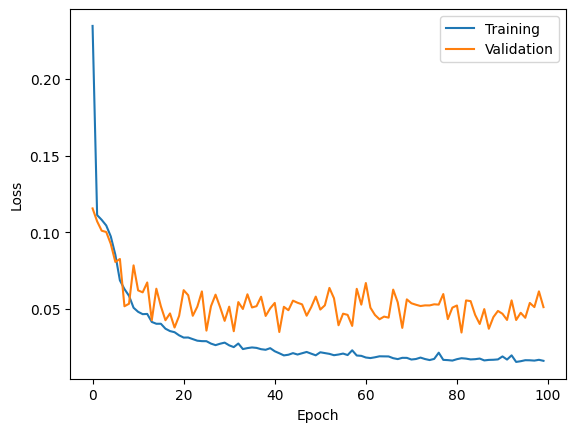

In [2]:
train_err=history.history['mean_absolute_error']
val_err=history.history['val_mean_absolute_error']
plt.figure()
plt.plot(train_err, label='Training')
plt.plot(val_err, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [3]:
# Baseline predictions using XTest
model = load_model('best_model_manual_tuning.keras')
pred_0 = model.predict(Xtest)
preds = []
# Get predictions with a feature randomized
for i in range(20):
    Xtest_rand = Xtest
    Xtest_rand[:,i] = np.random.uniform(0, 1, size=Xtest_rand.shape[0])
    preds.append(model.predict(Xtest_rand))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [4]:
# Array is shape (20, 819, 30) (feature randomized, sim #, output)
maes = []
preds_array = np.stack(preds)
reference_mae = mean_absolute_error(Ytest[:,0], pred_0[:,0])

# TE_4_t4000 Feature Importances correspond to (:,:,0)
for i in range(preds_array.shape[0]):
    # Find MAE with randomized feature - MAE with no feature randomized
    maes.append(mean_absolute_error(Ytest[:,0], preds_array[i,:,0]) - reference_mae) 
# Add change in MAE due to randomizations (aka feature importances) to DF and sort
out1_df = pd.DataFrame(np.stack(maes), columns=['Feature Importance'], index=xdf.columns, dtype=float)
out1_df_sorted = out1_df.sort_values(by='Feature Importance', key=abs, ascending=False)

maes = []
reference_mae = mean_absolute_error(Ytest[:,14], pred_0[:,14])
# TW_1_t8000 Feature Importances correspond to (:,:,14)
for i in range(preds_array.shape[0]):
    maes.append(mean_absolute_error(Ytest[:,14], preds_array[i,:,14]) - reference_mae) 
out2_df = pd.DataFrame(np.stack(maes), columns=['Feature Importance'], index=xdf.columns, dtype=float)
out2_df_sorted = out2_df.sort_values(by='Feature Importance', key=abs, ascending=False)

maes = []
reference_mae = mean_absolute_error(Ytest[:,24], pred_0[:,24])
# TN_1_1_t4000 Feature Importances correspond to (:,:,24)
for i in range(preds_array.shape[0]):
    maes.append(mean_absolute_error(Ytest[:,24], preds_array[i,:,24]) - reference_mae) 
out3_df = pd.DataFrame(np.stack(maes), columns=['Feature Importance'], index=xdf.columns, dtype=float)
out3_df_sorted = out3_df.sort_values(by='Feature Importance', key=abs, ascending=False)


Text(0.5, 1.0, 'Feature Importance on TN_1_1_t4000')

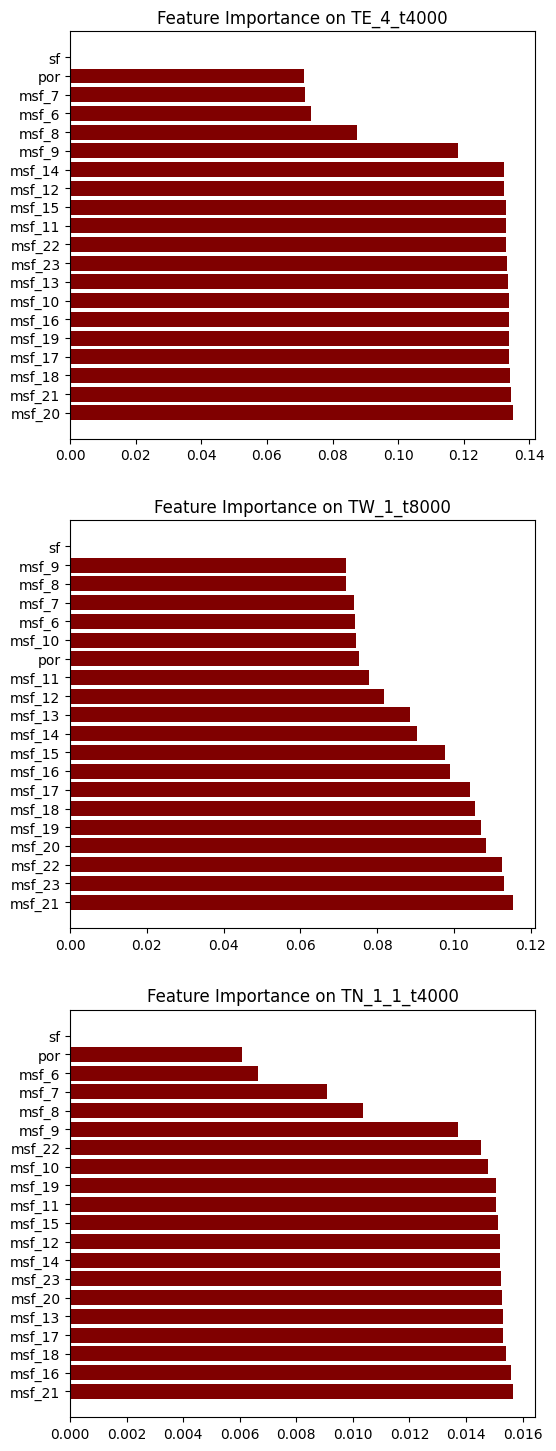

In [5]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(6,18)
ax[0].barh(out1_df_sorted.index.array, out1_df_sorted['Feature Importance'].values, color='maroon')
ax[0].set_title('Feature Importance on TE_4_t4000')
ax[1].barh(out2_df_sorted.index.array, out2_df_sorted['Feature Importance'].values, color='maroon')
ax[1].set_title('Feature Importance on TW_1_t8000')
ax[2].barh(out3_df_sorted.index.array, out3_df_sorted['Feature Importance'].values, color='maroon')
ax[2].set_title('Feature Importance on TN_1_1_t4000')

Here, feature importance represents the change in MAE due to the randomization of a paticular input. For all 3 outputs, sf was the least important feature. msf_20 through msf_23 were always important features for all outputs. And overall, TN_1_1_t4000 was the most robust to randomizations of features, although this is likely because its MAE was high to begin with.